# Breakout Train 🎮🕹️


## Packages

In [1]:
#!pip install gym[atari]

In [2]:
import random
import gym
import numpy as np
import matplotlib.pyplot as plt 
import time
from collections import deque
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Activation, Convolution2D, Permute
from keras.optimizers import Adam

/usr/local/insa/anaconda/envs/GPU/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Current directory setting

In [3]:
import os
if os.getcwd()[:8] == "/content" : 
    # Google Drive
    from google.colab import drive
    drive.mount('/content/drive/')
    os.chdir('/content/drive/My Drive/Colab Notebooks/Atari')
    !ls
else :
    # Linux INSA
    save = "/home/villegas/Documents/projet_5gmm/Atari/save"
    os.chdir(save)

## Class Agent

In [12]:
class DQN_Breakout_Agent:
    def __init__(self, action_size):
        self.samples_frame_size = 4
        self.state_size = (self.samples_frame_size, 84, 74)
        self.action_size = action_size
        
        self.memory = deque(maxlen=20000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.99995
        self.learning_rate = 0.00025
        self.model = self._build_model()
        self.current_state = deque(maxlen=self.samples_frame_size) # processing batch of frames

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        # Permute change 4x84x74 to 84x74x4
        model.add(Permute((2, 3, 1), input_shape=self.state_size))
        model.add(Convolution2D(32, (8, 8), strides=(4, 4)))
        model.add(Activation('relu'))
        model.add(Convolution2D(64, (4, 4), strides=(2, 2)))
        model.add(Activation('relu'))
        model.add(Convolution2D(64, (3, 3), strides=(1, 1)))
        model.add(Activation('relu'))
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation('relu'))
        model.add(Dense(4))
        model.add(Activation('linear'))
        model.compile(loss='mse',optimizer=Adam(lr=0.00025))
        return model
    
    # enregistre ce qu'il a fait et stock dans son deque(=liste avec limite)
    def remember(self, state, action, reward, next_frame, done):
        # state -> deque 4x84x74
        # next_frame -> array 84x74
        
        # between the current_state and the next one, 3 frames are the same and don't
        # need to stored twice -> let's just store the new frame on the next state
        self.memory.append((state, action, reward, next_frame, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size) # Hazard
        else :
            # Approximation de la ligne de la Q table avec le réseau de neurone
            batch_state = deque_to_batch(state)
            act_values = self.model.predict(batch_state) # Keras need a 1x4x84x74 batch
            return np.argmax(act_values[0])  # returns action ()
    
    def learn(self, state, action, reward, next_frame, done):
        batch_state = deque_to_batch(state)
        next_state = state
        next_state.append(next_frame)
        batch_next_state = deque_to_batch(next_state)
        
        target = reward
        if not done:
            target = (reward + self.gamma *
                      np.amax(self.model.predict(batch_next_state)[0]))
        target_f = self.model.predict(batch_state)
        target_f[0][action] = target
        self.model.fit(batch_state, target_f, epochs=1, verbose=0)
        
    # Rejoue et apprend batch_size événement au hazard dans son deque
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_frame, done in minibatch:
            self.learn(state, action, reward, next_frame, done)
            
    def refresh(self):
        if self.epsilon > self.epsilon_min :
            self.epsilon *= self.epsilon_decay
            
    # On initialise en écrasant tout     
    def init_current_state(self, frm):
        for i in range(self.samples_frame_size):
            self.current_state.append(frm)
        return self.current_state
    
    # update the 4 current batch frames
    def update_current_state(self, next_frame):
        self.current_state.append(next_frame)
        return self.current_state

    # Loading or saving neural network weights
    def load(self, name):
        self.model.load_weights(name)
    def save(self, name):
        self.model.save_weights(name)

## New fonctions

In [13]:
def preprocessing(img):
    """
    Gray-scale, reduce edges and down-sampling img to a 84×74 image
    """
    return np.mean(img, axis=2)[30:-12,6:-6][::2,::2].astype(np.uint8)

def reward_clipping(reward):
    """
    reward: negative -> -1; positive -> +1
    """
    return np.sign(reward)

def deque_to_batch(deque):
    """
    from frame_stack 4x84x74 to normalized batch 1x4x84x74
    """
    array_frame_stack = np.array(deque)              # convert deque into 4x84x74 array
    array_frame_stack = array_frame_stack.astype('float32') / 255. # normalize from [0,255] to [0,1]
    return np.expand_dims(array_frame_stack, axis=0) # add one dimension: 1x4x84x74 array

## Main

In [14]:
env = gym.make('Breakout-v4')
print("State size : %s\nAction size : %s"%(env.observation_space.shape,env.action_space.n))

State size : (210, 160, 3)
Action size : 4


In [15]:
agent = DQN_Breakout_Agent(action_size = env.action_space.n)

EPISODES = 232
batch_size = 32
TIME_LIMIT = int(1e8)
done = False
DISPLAY = True
tmps1=time.time()
score = 0

tt = [] # To see time evolution
for e in range(EPISODES):
    color_frame = env.reset()
    frame = preprocessing(color_frame)
    state = agent.init_current_state(frame) # Pour avoit un deque initiale 4x84x74
    
    for step in range(TIME_LIMIT):
        #env.render()        
        action = agent.act(state)
        color_next_frame, reward, done, info = env.step(action) # take a action
        
        # clips rewards to 1 or -1
        reward = reward_clipping(reward)
        if reward > 0 : score += 1
            
        # Dès qu'on perd une vie sur les 5, on considère qu'on a perdu
        if info['ale.lives'] < 5 :
            done = True

        # image preprocessing
        next_frame = preprocessing(color_next_frame) 
        
        # remember
        agent.remember(state, action, reward, next_frame, done)
        
        # update the current state 4x84x74
        state = agent.update_current_state(next_frame)
        
        # On se souvient tout les 4 coup et si on a joué au moins batch_size fois.
        if len(agent.memory) >= 10000 and step%4==0 : 
            agent.replay(batch_size)# On n'apprend que sur ses souvenirs, pas sur le coup immédiat
        
        # Stop the current game if it's done
        if done :
            break
            
    # update epsillon 
    if len(agent.memory) >= 10000 :
        agent.refresh() 
    
    # Display every 10 episode
    if DISPLAY and e%20==0 :
        print("episode: %s, previous score average: %.2f, e: %.3f"%(e,score/100,agent.epsilon))
        score = 0
        
    if e % 10 == 0:
        agent.save("breakout-dqn_tmp")
        
    tt.append(time.time()-tmps1)
        
tmps = time.time()-tmps1
print("Temps d'execution = %d min %.2fs" %(tmps//60,tmps%60))
env.close()

episode: 0, previous score average: 0.01, e: 1.000
episode: 20, previous score average: 0.01, e: 1.000
episode: 40, previous score average: 0.04, e: 1.000
episode: 60, previous score average: 0.06, e: 1.000
episode: 80, previous score average: 0.06, e: 1.000
episode: 100, previous score average: 0.02, e: 1.000
episode: 120, previous score average: 0.04, e: 1.000
episode: 140, previous score average: 0.03, e: 1.000
episode: 160, previous score average: 0.06, e: 1.000
episode: 180, previous score average: 0.07, e: 1.000
episode: 200, previous score average: 0.06, e: 1.000
episode: 220, previous score average: 0.04, e: 0.999
Temps d'execution = 1 min 55.14s


## Graphs

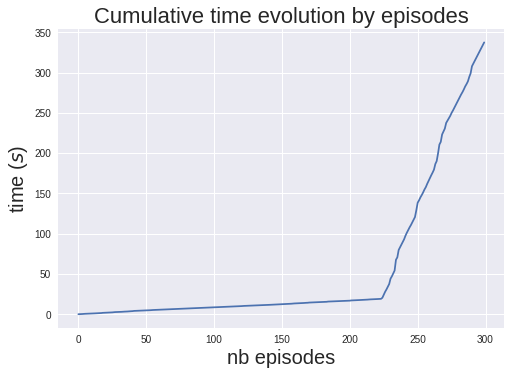

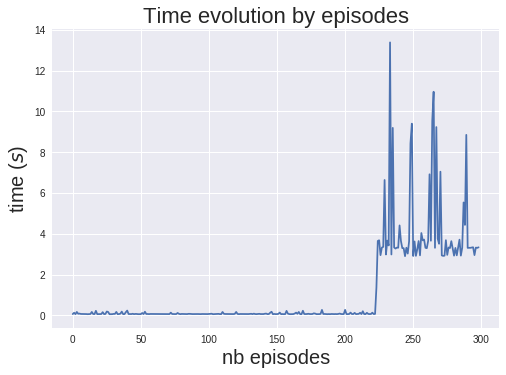

In [0]:
plt.plot(range(EPISODES),tt)
plt.xlabel("nb episodes",fontsize=20)
plt.ylabel("time ($s$)",fontsize=20)
plt.title("Cumulative time evolution by episodes", fontsize=22)
plt.show()

tt = np.array(tt)
plt.plot(range(EPISODES-1),tt[1:]-tt[:-1])
plt.xlabel("nb episodes",fontsize=20)
plt.ylabel("time ($s$)",fontsize=20)
plt.title("Time evolution by episodes", fontsize=22)
plt.show()

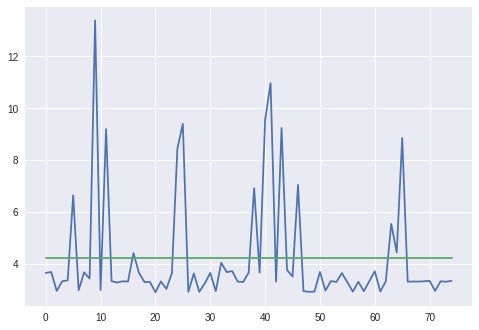

4.224968096415202


In [0]:
a = tt[224:]
a = a[1:]-a[:-1]
plt.plot(a)
plt.plot(np.ones(len(a))*np.mean(a))
plt.show()
print(np.mean(a))

In [0]:
print(4.22/4.57)

0.9234135667396061


Pour une partie à une seule vie:
> De 0 à 220 parties -> 0.068 secondes pour faire une partie

> Plus de 220 parties -> Il faut en moyenne 3 secondes pour faire une partie